## Implementing Federated Learning with PySyft

### Library Installation and Dataset Preparation

First, let's install the PySyft. PySyft is a library that provides training framework of federated learning.

In [10]:
# install syft [https://github.com/OpenMined/PySyft]
!pip install syft==0.2.9
!pip install torchvision==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 433 kB 38.3 MB/s 
     |████████████████████████████████| 73 kB 2.6 MB/s 
     |████████████████████████████████| 26.1 MB 128.8 MB/s 
     |████████████████████████████████| 4.0 MB 49.9 MB/s 
     |████████████████████████████████| 753.4 MB 8.5 kB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 126 kB 89.7 MB/s 
     |████████████████████████████████| 449 kB 90.3 MB/s 
     |████████████████████████████████| 484 kB 95.8 MB/s 
     |████████████████████████████████| 9.0 MB 55.5 MB/s 
     |████████████████████████████████| 1.8 MB 73.5 MB/s 
     |████████████████████████████████| 200 kB 64.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.1 MB/s 
     |████████████████████████████████| 66 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 57.1 MB/s 
     |████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next, let's get the COVID_CT dataset to perform classification task. With restricted shared link, we download the dataset to /content/ in colab.

In [11]:
# install PyDrive to get COVID_CT_Data
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!rm -r /content/COVID_CT.rar
if not os.path.exists('/content/COVID_CT.rar'):
    link = '1-WUlbrTQmlLTnrilrHqxIdMjBfL6gClX'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link}) 
    downloaded.GetContentFile('COVID_CT.rar')

The downloaded dataset is in rar format. We need to unrar it to data folder.

In [12]:
if not os.path.exists('/content/data/COVID_CT_data'):
  !unrar x '/content/COVID_CT.rar' -d '/content/data/' 

The published dataset is provided by [https://github.com/UCSD-AI4H/COVID-CT]. 

The COVID-CT-Dataset has 349 CT images containing clinical findings of COVID-19 from 216 patients. They are in ./images/CT_COVID/. And Non-COVID CT scans are in ./images/CT_NonCOVID/

They provide a data split in ./labels/CT_COVID/ and ./labels/CT_NonCOVID/.

The images are collected from COVID19-related papers from medRxiv, bioRxiv, NEJM, JAMA, Lancet, etc. CTs containing COVID-19 abnormalities are selected by reading the figure captions in the papers. All copyrights of the data belong to the authors and publishers of these papers.

### load Dataset

We define a class CovidCTDataset to read all the images and labels, and return dataset for further training in pytorch framework.

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms,models
import torch.optim as optim
import os

# Custom dataset
#from https://github.com/UCSD-AI4H/COVID-CT/blob/master/baseline%20methods/DenseNet169/DenseNet_predict.py
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.data = []
        self.targets = []
        img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,'images',self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            img_list += cls_list
        for item in img_list:
          self.data.append(item[0])
          self.targets.append(item[1])

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_path = self.data[idx][0]
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        # label = int(self.data[idx][1])
        label = int(self.targets[idx])
        return image, label



def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

With structured dataset, we load images from ./images/CT_COVID/ and ./images/CT_NonCOVID/, and labels from ./labels/CT_COVID/ and ./labels/CT_NonCOVID/.

With class CovidCTDataset, we collect all the images including COVID-CT and Non-COVID-CT with their labels. 

In [14]:
batchsize=16
base_path = '/content/data/COVID_CT_data/'
img_path = os.path.join(base_path, 'images')
label_path = os.path.join(base_path, 'labels')



# Transforms used for datasets
train_transforms = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# get train set
trainset = CovidCTDataset(root_dir=base_path, 
                              txt_COVID=label_path+'/CT_COVID/trainCT_COVID.txt',
                              txt_NonCOVID=label_path+'/CT_NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transforms)
 
# get test set    
testset = CovidCTDataset(root_dir=base_path,
                              txt_COVID=label_path+'/CT_COVID/testCT_COVID.txt',
                              txt_NonCOVID=label_path+'/CT_NonCOVID/testCT_NonCOVID.txt',
                              transform= test_transforms)

print("Number of Classes: ",len(trainset.classes))
print("Size of trainset:{0}, testset:{1}".format(len(trainset), len(testset)))


Number of Classes:  2
Size of trainset:543, testset:203


Now we can visualize some images with their labels in the dataset. The size of images is 16\*3\*224\*224 where 16 is the batch size, 3 is the RGB channels, and 224 is the width/height.

 Image Size torch.Size([16, 3, 224, 224])


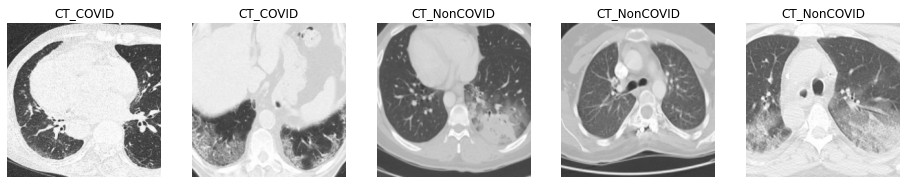

In [15]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the train set
images, labels = next(iter(data_loader)) 
print(" Image Size",images.size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for i in range(5):
    ax = axes[i]
    label = labels[i].to('cpu').numpy()
    if label == 0:
      ax.set_title('CT_COVID')
    else:
      ax.set_title('CT_NonCOVID')
    imshow(images[i], ax=ax, normalize=True)

### Build Toy ConvNet

This toy ConvNet contains 3 Conv-BN-ReLU layers and 2 max pooling layers. The classifier contains 3 fully-connected layer with BN and ReLU as activation funtion. 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ToyConvNet(nn.Module):
    def __init__(self):
        super(ToyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn4 = nn.BatchNorm1d(num_features=512)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        # x of shape [B, 3, 224, 224]
        x = self.conv1(x) # -> [B, 16, 112, 112]
        x = self.relu(self.bn1(x)) # -> [B, 16, 112, 112]
        x = self.pool(x) # -> [B, 16, 56, 56]
        x = self.conv2(x) # -> [B, 32, 28, 28]
        x = self.relu(self.bn2(x)) # -> [B, 32, 28, 28]
        x = self.pool(x) # -> [B, 32, 14, 14]
        x = self.conv3(x) # -> [B, 64, 7, 7]
        x = self.relu(self.bn3(x)) # -> [B, 64, 7, 7]

        x = x.view(-1, 64 * 7 * 7) # -> [B, 3136]
        x = self.fc1(x) # -> [B, 512]
        x = self.relu(self.bn4(x)) # -> [B, 512]
        x = self.fc2(x) # -> [B, 128]
        x = self.relu(self.bn5(x)) # -> [B, 128]
        x = self.fc3(x) # -> [B, 2]
        return x

    def name(self):
        return "ToyConvNet"

Before utilize Pysyft to perform Federated learning, we show how syft send messages.

In [17]:
import torch
import syft as sy

# we hook pytorch first
hook = sy.TorchHook(torch)
# Then, we create the VirtualWorkers:
bob = sy.VirtualWorker(hook, id='bob')

# We first send a tensor to bob
print("Sending a tensor x to bob")
x = torch.Tensor([2,2,2]).send(bob)
print(x)
print()
# We can check the location of this tensor
print("Check the location of tensor x: {0}".format(x.location))
print()
# We the send another tensor to bob
print("Sending a tensor y to bob")
y = torch.Tensor([1,2,3]).send(bob)
# Sum two tensors locally
print("sum x and y")
sum = x + y
print(sum)
print()
# Get the sum back
print("Get the sum")
sum = sum.get()
print(sum)

Sending a tensor x to bob
(Wrapper)>[PointerTensor | me:64360134341 -> bob:73912818954]

Check the location of tensor x: <VirtualWorker id:bob #objects:51>

Sending a tensor y to bob
sum x and y
(Wrapper)>[PointerTensor | me:39238719084 -> bob:79961636574]

Get the sum
tensor([3., 4., 5.])


Now we can use Pysoft to utilize Federated Learning for the optimization of this toy Conv Net on this COVID-CT dataset.

In [23]:
import torch
import syft as sy
from syft.federated.floptimizer import Optims

# set standard parameters
epochs = 10
lr = 1e-4
batchsize = 16
weight_decay = 5e-4

# we hook pytorch first
hook = sy.TorchHook(torch)
# We create the VirtualWorkers:
alice = sy.VirtualWorker(hook, id='alice')
bob = sy.VirtualWorker(hook, id='bob')
workers = ['alice', 'bob']

# Creating federated dataloaders, an extension of Pytorch DataLoader class
federated_train_loader = sy.FederatedDataLoader(
    trainset.federate((alice, bob)), batch_size=batchsize, shuffle=True)
federated_test_loader = sy.FederatedDataLoader(
    testset.federate((alice, bob)), batch_size=batchsize, shuffle=False)
# testloader = DataLoader(testset, batch_size=batchsize, shuffle=False, num_workers=1)

# define your components as usual
model = ToyConvNet()
# Apply Adam optimizer
adam_opt = optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = Optims(workers, optim=adam_opt) # federated optimizer
# define loss function
criterion = nn.CrossEntropyLoss()
# define LR schduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam_opt, float(epochs))

# start training
for epoch in range(1, epochs + 1):
    model.train()
    scheduler.step()
    lr = scheduler.get_lr()[0]
    train_losses = []
    train_correct = 0.0
    train_total = 0.0
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        # Location of current batch
        worker = data.location
        # print(f'Current Worker {worker}')
        # Send model to current worker
        model.send(worker)
        # Setting accumulated gradients to zero before backward step
        opt = optimizer.get_optim(worker.id)
        opt.zero_grad()
        # Output from the model
        output = model(data)
        # Calculate the loss and perform backprop
        loss = criterion(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        # Backpropagation step
        opt.step()
        # Get the model back
        model.get()
        train_losses.append(loss.get().item())
        # convert output probabilities to predicted class
        pred = output.get().data.max(1, keepdim=True)[1]
        # compare predictions to true label
        train_correct += np.sum(np.squeeze(pred.eq(target.get().data.view_as(pred))).cpu().numpy())
        train_total += data.get().size(0)
    train_acc = 100. * train_correct / train_total
    print("Epoch: {0}, LR: {1:.2E}, Train_Loss: {2:.2f}, Train_Acc:{3:.2f}".format(epoch, lr, np.mean(train_losses), train_acc))

    # Now we can evaluate the performance on testset
    model.eval()
    test_losses = []
    test_correct = 0.0
    test_total = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(federated_test_loader):
            # get current location
            worker = data.location
            # Send model to current worker
            model.send(worker)
            # Output from the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Get the model back
            model.get()
            test_losses.append(loss.get().item())
            # convert output probabilities to predicted class
            pred = output.get().data.max(1, keepdim=True)[1]
            # compare predictions to true label
            test_correct += np.sum(np.squeeze(pred.eq(target.get().data.view_as(pred))).cpu().numpy())
            test_total += data.get().size(0)
        test_acc = 100. * test_correct / test_total
    print("Test_Loss:{0:.2f}, Test_Acc:{1:.2f}".format(np.mean(test_losses), test_acc))

Epoch: 1, LR: 9.52E-05, Train_Loss: 0.72, Train_Acc:51.75
Test_Loss:0.69, Test_Acc:49.26
Epoch: 2, LR: 8.39E-05, Train_Loss: 0.65, Train_Acc:61.33
Test_Loss:0.68, Test_Acc:52.71
Epoch: 3, LR: 6.97E-05, Train_Loss: 0.60, Train_Acc:73.11
Test_Loss:0.72, Test_Acc:49.75
Epoch: 4, LR: 5.40E-05, Train_Loss: 0.55, Train_Acc:79.93
Test_Loss:0.72, Test_Acc:46.31
Epoch: 5, LR: 3.82E-05, Train_Loss: 0.53, Train_Acc:84.53
Test_Loss:0.72, Test_Acc:47.78
Epoch: 6, LR: 2.39E-05, Train_Loss: 0.49, Train_Acc:88.58
Test_Loss:0.72, Test_Acc:49.75
Epoch: 7, LR: 1.23E-05, Train_Loss: 0.48, Train_Acc:89.13
Test_Loss:0.73, Test_Acc:50.74
Epoch: 8, LR: 4.42E-06, Train_Loss: 0.46, Train_Acc:89.13
Test_Loss:0.75, Test_Acc:50.74
Epoch: 9, LR: 6.27E-07, Train_Loss: 0.45, Train_Acc:92.08
Test_Loss:0.73, Test_Acc:51.23
Epoch: 10, LR: 0.00E+00, Train_Loss: 0.44, Train_Acc:88.95
Test_Loss:0.73, Test_Acc:53.69


# Practice Questions

1. Try to modfiy Tony Conv Net and fit again, see what will happen.

2. Explore syft modules